In [42]:
# Welcome to Huichen's code broken down to understand how to use different functions in SKLEARN
# the documentation for sk learn can be found at this link. http://scikit-learn.org/stable/documentation.html


In [1]:
# First step is to import some packages. 
# Pandas will be used to read and manipulate the data in the CSV file
# numpy is required to compute math
# matplotlib is required to be able to graph our results
# time will be used to calculate the amount of time it takes to run cells. 
# the documentation for these libraries can be found online 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


In [44]:
%%time
df = pd.read_csv('16mInfo+reqTM.csv')

# the first line in this cell is "magic" that is only used in jupyter notebooks. It will print the CPU and Wall times for the cell
# the second line in this cell is the pandas command for reading the CSV file into a dataframe.


# from this moment on the data is stored in a Pandas DataFrame Object. This object is very powerful as you can apply
# many different functions that would normally require a database. The full documentation for Pandas can be found
# https://pandas.pydata.org/pandas-docs/stable/



Wall time: 2min 18s


In [45]:
# print out the shape of the dataframe, this is done to confirm the CSV was loaded properly. Format (row, col)

df.shape



(16000001, 51)

In [46]:
# filter the users whose submission jobs are less than 200 
# this is first done by using the groupby function on the dataframe and setting that equal to another variable
# then the filter function is run.
gd = df.groupby('owner')
t1 = gd.filter(lambda x : len(x) > 200)
t1.shape

(15985764, 51)

In [47]:
# drop NAN values, what this means is that we want to drop all NULL values which are represented as NaN in Python
t2 = t1.dropna()
t2.shape

(15964540, 51)

In [48]:
# reduce columns, here Huichen decided to use only 9 (columns), these are the columns that will be used in regression and classification

temp = t2[['owner', 'failed', 'project', 'cpu', 'maxvmem', 'reqTime', 'reqMem', 'people','mem']]

In [49]:
%%time
# average usage of cpu , maxvmem, requested time, requested memory for each user. Basically what we are creating here is
# another dataframe with aggregations (in this case we are calculating the mean accross all rows for the given columns)
average = temp.groupby('owner', as_index=False)['cpu','maxvmem','reqTime','reqMem','mem'].mean()



Wall time: 1.38 s


In [50]:
# rename column name, this is done so we can easily access the columns with new names. Huichen decided to put 'a' infront
# this means that they are averages or aggregates.
average.columns = ['owner','aCPU','aMaxvmem','aReqtime','aReqmem','aMem']

In [51]:
# this is similar to a inner join in SQL on the column 'owner'. Since both temp and average have a columnt 'owner' this
# is easily done

t3 = pd.merge(temp, average, on=['owner'])
t3.columns

Index(['owner', 'failed', 'project', 'cpu', 'maxvmem', 'reqTime', 'reqMem',
       'people', 'mem', 'aCPU', 'aMaxvmem', 'aReqtime', 'aReqmem', 'aMem'],
      dtype='object')

In [52]:
# now, our original dataset has over 16 million rows. This would take too long to run various algorithms on so we will
# instead use a sample of 1 million.


newdf = t3.sample(n=1000001)

In [53]:
newdf.shape

(1000001, 14)

In [54]:
# change value of attribute failed to binary. This is important to do since we are wanting to predict this feature.
# making it a binary type makes it a usable dependent variable for many of the algorithms we will run later. 
newdf['failed'] = (newdf['failed'] > 0).astype(int)

In [55]:
# add unique columns as features, id by owner, project_id by project(similar with department), this is a new way to 
# identify the columns, by assigining them a number. The get_dummies "convert categorical variable into dummy/indicator variables"
# the documentation along with some examples of what this function does can be found on
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
newdf['id'] = pd.factorize(newdf.owner)[0]
newdf['project_id'] = pd.factorize(newdf.project)[0]
newdf = pd.get_dummies(newdf, columns=['people'])

In [56]:
newdf.columns

Index(['owner', 'failed', 'project', 'cpu', 'maxvmem', 'reqTime', 'reqMem',
       'mem', 'aCPU', 'aMaxvmem', 'aReqtime', 'aReqmem', 'aMem', 'id',
       'project_id', 'people_Faculty', 'people_Graduate',
       'people_PostDoctoralResearcher', 'people_ResearchAssociate',
       'people_Staff', 'people_Undergraduate', 'people_Unknowing'],
      dtype='object')

In [57]:
# we are going to drop owner and project the columns (this is why we have axis set to 1)
# the documentation on how to use pandas drop can be found on
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
# axis : {0 or ‘index’, 1 or ‘columns’}, default 0
fdf = newdf.drop(['owner','project'], axis=1)
fdf.columns

Index(['failed', 'cpu', 'maxvmem', 'reqTime', 'reqMem', 'mem', 'aCPU',
       'aMaxvmem', 'aReqtime', 'aReqmem', 'aMem', 'id', 'project_id',
       'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher',
       'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate',
       'people_Unknowing'],
      dtype='object')

In [58]:
# this allows us to see the first 5 rows of the dataframe and manually inspect if it looks ready to be use used for ML
fdf.head(5)

,failed,cpu,maxvmem,reqTime,reqMem,mem,aCPU,aMaxvmem,aReqtime,aReqmem,aMem,id,project_id,people_Faculty,people_Graduate,people_PostDoctoralResearcher,people_ResearchAssociate,people_Staff,people_Undergraduate,people_Unknowing
6380784,0,72.50,1.508639e+08,7200.0,1.0,8.675896,761.349945,2.033148e+08,8128.816356,1.339869,3.130181e+03,0,0,0,0,0,0,0,0,1
1122535,0,186.02,2.637828e+09,10800.0,1.0,43.929626,1585.170160,3.451968e+09,38385.321212,1.001895,2.674659e+03,1,1,0,1,0,0,0,0,0
14043030,0,1.91,1.094451e+07,72000.0,1.0,0.003799,3274.571872,1.365943e+09,66348.698907,4.493323,2.798343e+07,2,2,0,0,0,1,0,0,0
3466558,0,38.09,6.008304e+09,3600.0,4.0,185.512542,9139.868182,6.336918e+09,16364.357704,5.907272,1.832671e+04,3,1,0,0,0,0,1,0,0
2993338,0,14669.39,1.521558e+10,345600.0,12.0,206021.290481,9139.868182,6.336918e+09,16364.357704,5.907272,1.832671e+04,3,1,0,0,0,0,1,0,0


In [59]:
%%time
# here we are going to write the data out to a csv file.
fdf.to_csv('experiment1.csv')

Wall time: 22.9 s


In [60]:
#===============start regression===============

In [61]:
# Here we are going to import all of the different models that will be used to run regression algorithms on the data set
# all of these belong to sklearn. 

from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import LassoLarsIC

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV

from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.linear_model import ARDRegression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [62]:
# we are going to create a list of models that we will add all of the different SKlearn models we will run so we can
# easily loop and run all the different tests.

models = []
models.append(('LR', LinearRegression()))

#models.append(('LassoCV', LassoCV()))
#models.append(('LassoLarsCV', LassoLarsCV()))
models.append(('LassoLarsIC', LassoLarsIC()))

models.append(('ElasticNetCV', ElasticNetCV()))

models.append(('Ridge', Ridge()))
#models.append(('RidgeCV', RidgeCV()))

#models.append(('OrthogonalMatchingPursuitCV', OrthogonalMatchingPursuitCV()))

#models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
##models.append(('SVR', SVR()))

In [63]:
# this is going to be our base 'x' data set
xt = fdf[['failed', 'cpu', 'maxvmem', 'reqMem', 'reqTime', 'id', 'project_id', \
          'aCPU', 'aMaxvmem', 'aReqtime', 'aReqmem', \
       'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher', \
       'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate', \
       'people_Unknowing']]
xt.shape

(1000001, 18)

In [64]:
# same as above but this data set is centered around memory
xt = fdf[['maxvmem', 'reqMem', 'id', 'project_id', \
       'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher', \
       'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate', \
       'people_Unknowing', 'aMaxvmem', 'aReqmem','mem']]
xt.shape
type(fdf)

pandas.core.frame.DataFrame

In [65]:
# same as above this data set is centered around cpu
xt = fdf[['cpu', 'reqTime', 'id', 'project_id', \
       'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher', \
       'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate', \
       'people_Unknowing', 'aMem', 'aCPU','aReqtime']]
xt.shape
type(xt)

pandas.core.frame.DataFrame

In [66]:
# scikit learn machine learning algorithms can't use the raw Pandas dataframe format. 
# As it says in the documentation for scikit learn, "standardization of a dataset is a common requirement for many machine learning estimators
# they might behave badly if the individualk feature do not more or less look like standard normally distributed data."
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
type(xt)
a = xt.sample(frac=0.1) # only added this line because for some reason it was changing XT to a ndarray which doesn't have the 
# attribute sample which was crashing the code.
xt = preprocessing.StandardScaler().fit_transform(a)

In [67]:
# we are going to use python list splicing to create data sets for x and y.

#array = xt.values
x = xt[:,1:16]
y = xt[:, 0]

In [68]:
# we are going to run a built in model selection to create x's traning and validation set as well as y's. 
x_train, x_validation, y_train, y_validation = model_selection.train_test_split(x, y, test_size=0.2, random_state=7)

In [69]:
%%time
# we will run Decision tree regressor
# the information about this function and what it does can be found on
# http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

#m = Lasso(alpha=0.15, fit_intercept=False, tol=0.00000000000001, max_iter=1000000, positive=True)
#m = DecisionTreeRegressor()
m = DecisionTreeRegressor()
m.fit(x_train, y_train)
print(r2_score(y_validation, m.predict(x_validation)))

-0.028431947070002073
Wall time: 181 ms


In [70]:
# here comes the loop that will run all of the models that we had added to the model. We will print out the reults of the time
# the r2 and algorithm scores.

results = []
names = []
r2 = []
times = []
for name, model in models:
 
  kfold = model_selection.KFold(n_splits=10, random_state=7)
  cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
   
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
  s = time.time()    
  model.fit(x_train, y_train)
  y_pred_test = model.predict(x_validation)
  r2s = r2_score(y_validation, y_pred_test)
  e = time.time()
  t = e - s
  times.append(t)
  print('time: ', t)
  r2.append(r2s)
  print('r2: ', r2s)

LR: -0.690401 (0.741055)
time:  0.039958953857421875
r2:  0.05615394929392514
LassoLarsIC: -0.690003 (0.740666)
time:  0.04795074462890625
r2:  0.05629204181192282
ElasticNetCV: -0.679928 (0.741632)
time:  0.5963897705078125
r2:  0.05178995107725848
Ridge: -0.690408 (0.741046)
time:  0.020978927612304688
r2:  0.05623388937845164
CART: -0.809763 (0.738664)
time:  0.146867036819458
r2:  -0.028607533222381853


In [71]:
#===============end regression===============

In [72]:
#=================start classification=================


# The steps bellow are very similar to the ones above. I believe that it would be redundant if I were to explain procedure twice.
# It would be a good excersise for the rest of the notebook for students to read thru the code and identify what they do. 

In [73]:
# Here we are going to import all of the different models that will be used to run classification algorithms on the data set
# all of these belong to sklearn. 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [74]:
fdf.columns

Index(['failed', 'cpu', 'maxvmem', 'reqTime', 'reqMem', 'mem', 'aCPU',
       'aMaxvmem', 'aReqtime', 'aReqmem', 'aMem', 'id', 'project_id',
       'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher',
       'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate',
       'people_Unknowing'],
      dtype='object')

In [75]:
xt = fdf[['failed', 'reqTime', 'reqMem','id', 'project_id', \
          'aCPU', 'aReqtime', 'aReqmem', \
       'people_Faculty', 'people_Graduate', 'people_PostDoctoralResearcher', \
       'people_ResearchAssociate', 'people_Staff', 'people_Undergraduate', \
       'people_Unknowing']]
xt.shape

(1000001, 15)

In [76]:
xt.iloc[:,1:3].head(3)

,reqTime,reqMem
6380784,7200.0,1.0
1122535,10800.0,1.0
14043030,72000.0,1.0


In [77]:
array = xt.values
x = array[:,1:16]
y = array[:, 0]

In [78]:
x_train, x_validation, y_train, y_validation = model_selection.train_test_split(x, y, test_size=0.2, random_state=7)


In [79]:
%%time
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
predictions = clf.predict(x_validation)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))


0.9659301703491483
[[189076    922]
 [  5892   4111]]
             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98    189998
        1.0       0.82      0.41      0.55     10003

avg / total       0.96      0.97      0.96    200001

Wall time: 11.4 s


accuracy score:  0.9486302568487157
LR: 0.949592 (0.000802)
time:  178.42974495887756
accuracy score:  0.9658701706491467
CART: 0.966635 (0.000597)
time:  47.95025396347046
accuracy score:  0.9278103609481952
NB: 0.928796 (0.001026)
time:  7.238588333129883
accuracy score:  0.9660151699241504
RF: 0.966550 (0.000538)
time:  126.09692049026489
Wall time: 5min 59s


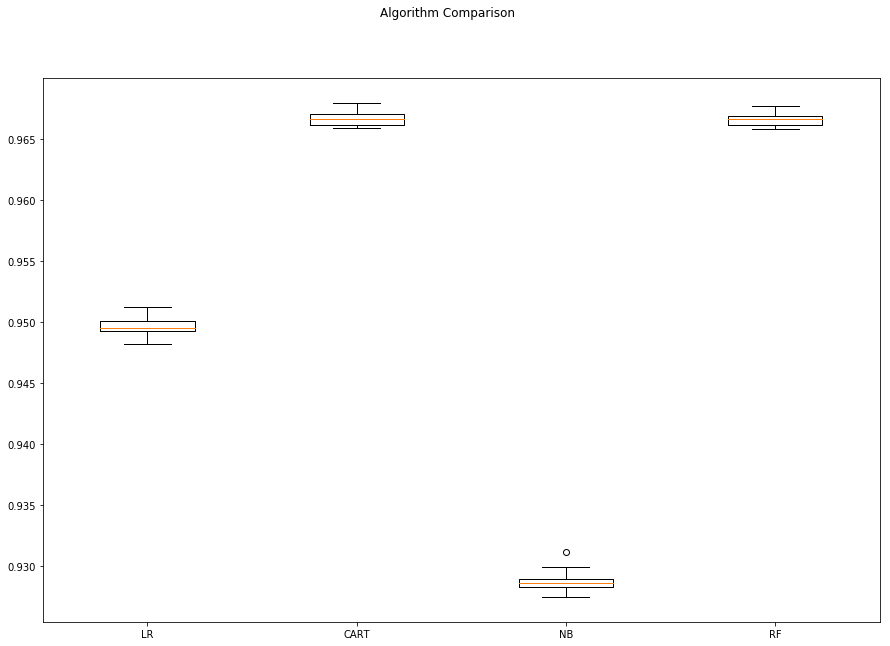

In [80]:
%%time
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
times = []
scoring = 'accuracy'
for name, model in models:
    s = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    model.fit(x_train, y_train)
    predictions = model.predict(x_validation)
    print('accuracy score: ', accuracy_score(y_validation, predictions))
    e = time.time()
    print(msg)
    times.append(e - s)
    print('time: ',e - s)
    s = 0
    e = 0
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
#plt.savefig('classification1m.jpg')
#plt.show()